In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (10, 5)

In [0]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [0]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [0]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

Text(0, 0.5, 'y')

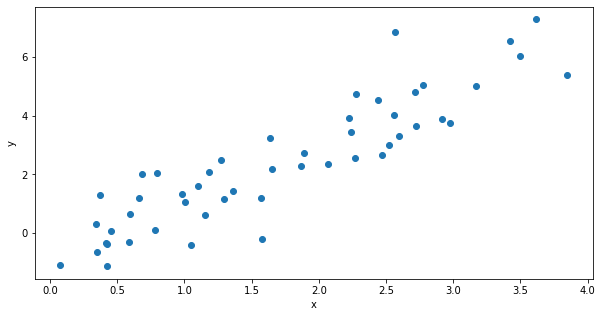

In [11]:
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

In [0]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": 0,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}  

In [0]:
def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

In [0]:
iters = 1000
trace = gibbs(y, x, iters, init, hypers)

Text(0, 0.5, 'Parameter value')

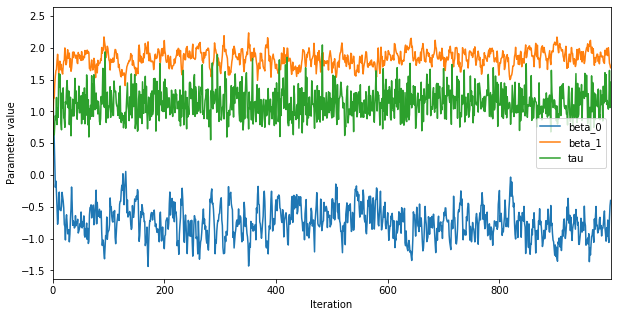

In [15]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

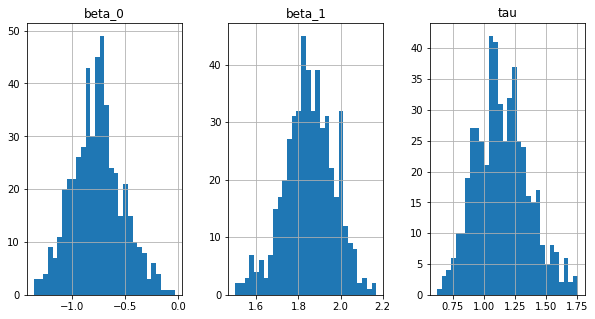

In [16]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

In [17]:
print(trace_burnt.median())
print(trace_burnt.std())

beta_0   -0.762393
beta_1    1.850307
tau       1.131047
dtype: float64
beta_0    0.236690
beta_1    0.118589
tau       0.216019
dtype: float64


Another Gibbs Sampler to fit y = mx + c

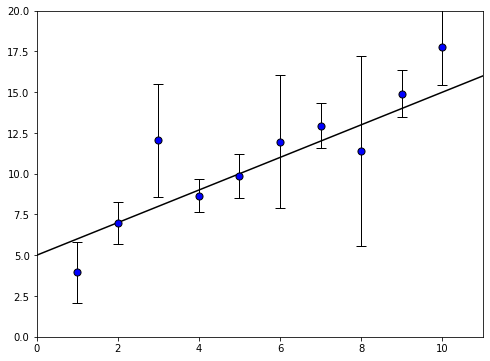

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set the minimum error for each measurement.
error_floor = 0.25

m = 1
c = 5

x_vals = np.arange(1, 11).astype(float)
y_vals = m*x_vals + c

y_errs = 1. + np.random.randn(10)**2

y_vals += y_errs*np.random.randn(10)

x = np.arange(0, 11, 0.01)

plt.figure(figsize=(8, 6))
plt.xlim(0, 11)
plt.ylim(0, 20)
plt.plot(x, m*x + c, color="black")
plt.errorbar(x_vals, y_vals, y_errs, ls="", capsize=5, color="black", lw=1)
plt.scatter(x_vals, y_vals, color="blue", lw=1, edgecolor="black", zorder=10, s=50)
plt.show()

In [0]:
def sample_m(param):

    c = param[1]

    mu_m_num = (np.sum(y_vals*x_vals/y_errs**2) - c*np.sum(x_vals/y_errs**2))
    inv_sigma_m_sq = np.sum(x_vals**2/y_errs**2)

    mu_m = mu_m_num/inv_sigma_m_sq
    sigma_m = 1./np.sqrt(inv_sigma_m_sq)

    return sigma_m*np.random.randn() + mu_m


def sample_c(param):

    m = param[0]

    mu_c_num = np.sum(y_vals/y_errs**2) - m*np.sum(x_vals/y_errs**2)
    inv_sigma_c_sq = np.sum(1./y_errs**2)

    mu_c = mu_c_num/inv_sigma_c_sq
    sigma_c = 1./np.sqrt(inv_sigma_c_sq)

    return sigma_c*np.random.randn() + mu_c

In [0]:
# Number of steps we will take
n_samples = 11000

# Starting parameter values
param = np.zeros(2)

# Vectors to hold our samples
m_samp = np.zeros(n_samples)
c_samp = np.zeros(n_samples)

for i in range(1, n_samples):
    param_order = np.random.choice(np.arange(2), 2, replace=False)

    for k in param_order:
        if k == 0:
            m_samp[i] = sample_m(param)
            param[0] = np.copy(m_samp[i])

        else:
            c_samp[i] = sample_c(param)
            param[1] = np.copy(c_samp[i])

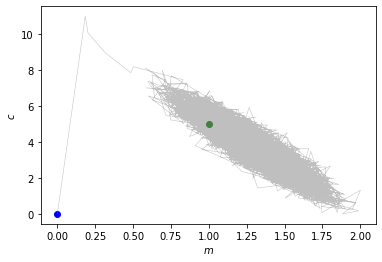

In [21]:
plt.figure()
plt.scatter(m_samp[0], c_samp[0], color="blue")
plt.scatter(m, c, color="green")
plt.plot(m_samp, c_samp, color="gray", alpha=0.5, lw=0.5)
plt.xlabel("$m$")
plt.ylabel("$c$")
plt.show()

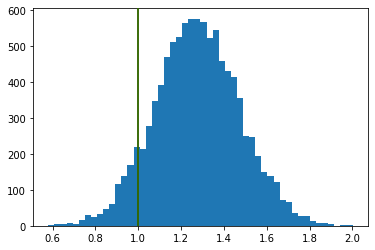

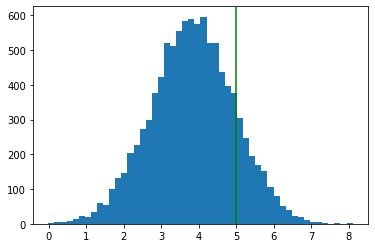

In [22]:
m_samp_burn = m_samp[1000:]
c_samp_burn = c_samp[1000:]

plt.figure()
plt.hist(m_samp_burn, bins=50)
plt.axvline(m, color="red", zorder=10)
plt.axvline(m, color="green", zorder=10)
plt.show()

plt.figure()
plt.hist(c_samp_burn, bins=50)
plt.axvline(c, color="green", zorder=10)
plt.show()

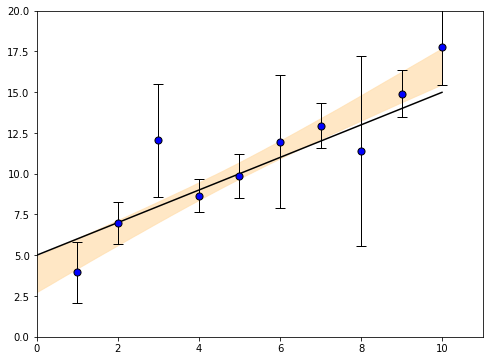

In [23]:
x = np.arange(0, 10, 0.01)

y_posterior = np.expand_dims(x, 1)*m_samp_burn + c_samp_burn

y_quantiles = np.percentile(y_posterior, (16, 84), axis=1)

plt.figure(figsize=(8, 6))
plt.xlim(0, 11)
plt.ylim(0, 20)
plt.fill_between(x, y_quantiles[0,:], y_quantiles[1,:], color="navajowhite", alpha=0.7)
plt.plot(x, m*x + c, color="black")
plt.errorbar(x_vals, y_vals, y_errs, ls="", capsize=5, color="black", lw=1)
plt.scatter(x_vals, y_vals, color="blue", lw=1, edgecolor="black", zorder=10, s=50)
plt.show()